# EXAMEN SERIES TEMPORALES

## Aitor Larrinoa Rementería
### Máster en Data Science
### Curso 2021-2022


## Librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
import datetime

In [59]:
import pyarrow.parquet as pq
import pyarrow as pa

## Lectura de los datos

In [3]:
datos_horarios = pd.read_excel("/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/data/EXAM/DemandaEnergia.xlsx",
             sheet_name=0)
datos_horarios = datos_horarios.drop(["Region", "UTC time", "Time zone"], axis=1)
datos_horarios

,Local date,Local hour,Local time,D
0,2015-07-01,1,2015-07-01 01:00:00,38210
1,2015-07-01,2,2015-07-01 02:00:00,35171
2,2015-07-01,3,2015-07-01 03:00:00,33243
3,2015-07-01,4,2015-07-01 04:00:00,31955
4,2015-07-01,5,2015-07-01 05:00:00,31199
...,...,...,...,...
56267,2021-11-30,11,2021-11-30 11:00:00,29068
56268,2021-11-30,12,2021-11-30 12:00:00,28769
56269,2021-11-30,13,2021-11-30 13:00:00,29180
56270,2021-11-30,14,2021-11-30 14:00:00,29719


In [4]:
datos_horarios_formato_1 = datos_horarios.drop(["Local hour"], axis=1)
datos_horarios_formato_1.index = datos_horarios_formato_1["Local time"]
datos_horarios_formato_1 = datos_horarios_formato_1.drop("Local time", axis=1)
datos_horarios_formato_1

,Local date,D
Local time,,
2015-07-01 01:00:00,2015-07-01,38210
2015-07-01 02:00:00,2015-07-01,35171
2015-07-01 03:00:00,2015-07-01,33243
2015-07-01 04:00:00,2015-07-01,31955
2015-07-01 05:00:00,2015-07-01,31199
...,...,...
2021-11-30 11:00:00,2021-11-30,29068
2021-11-30 12:00:00,2021-11-30,28769
2021-11-30 13:00:00,2021-11-30,29180


In [5]:
datos_horarios_formato_2 = datos_horarios_formato_1

En un año hay 365 días y si multiplicamos 365*24=8760. Luego, deberíamos tener 8760 filas en cada año del dataset, excepto en los años bisiestos. En estos años deberíamos tener 366*24=8784. Los años bisiestos en nuestro dataset son *2016* y *2020*. 

In [6]:
dict_comprobacion=dict()
for año in range(2015,2022):
    suma = datos_horarios_formato_1[str(año)].count()
    dict_comprobacion[año] = suma
dict_comprobacion

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_10064/1000893638.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  suma = datos_horarios_formato_1[str(año)].count()


{2015: Local date    4416
 D             4416
 dtype: int64,
 2016: Local date    8784
 D             8784
 dtype: int64,
 2017: Local date    8760
 D             8760
 dtype: int64,
 2018: Local date    8760
 D             8760
 dtype: int64,
 2019: Local date    8760
 D             8760
 dtype: int64,
 2020: Local date    8784
 D             8784
 dtype: int64,
 2021: Local date    8008
 D             8008
 dtype: int64}

Podemos comprobar que todos los años cumplen este requisito excepto el 2015 (sus datos comienzan en julio) y 2021(sus datos acaban en noviembre). Veamos si los datos que tenemos de los años 2015 y 2021 son completos.
- **2015**. Debemos considerar datos desde julio hasta diciembre (ambos incluidos), luego son (31*4+30*2)(días)*24(horas)=4416. Luego, el dato es correcto
- **2021**. Eliminamos los datos del mes de diciembre al total. 8760-(31*24) = 8016. Pero, como los datos acaban a las 15:00 debemos eliminar las horas desde las 16:00 hasta las 23:00 (en total 8 horas). 8016-8 = 8008.

Luego, concluimos que están todos los datos en nuestro dataset.

Deberemos introducir datos en el dataset horario debido a que nos faltan los datos de 8 horas en el último día de noviembre del año 2021. 

In [7]:
list_hours=list()
for i in range(1,24):
    list_hours.append(i)
    
list_hours.append(0)

for año in range(2015,2021):
    #if año == 2015:
    #    datos_2015 = datos_horarios_formato_1[str(año)+"-11-30"]
    #    datos_2015.columns = ["D_2015"]
    #    datos_2015.index = list_hours
    #elif año == 2016:
    #    datos_2016 = datos_horarios_formato_1[str(año)+"-11-30"]
    #    datos_2016.columns = ["D_2016"]
    #    datos_2016.index = list_hours
    if año == 2017:
        datos_2017 = datos_horarios_formato_1[datos_horarios_formato_1["Local date"] == str(año)+"-11-30"]
        datos_2017.columns = ["local_date", "D_2017"]
        datos_2017.index = list_hours
    elif año == 2018:
        datos_2018 = datos_horarios_formato_1[datos_horarios_formato_1["Local date"] == str(año)+"-11-30"]
        datos_2018.columns = ["local_date", "D_2018"]
        datos_2018.index = list_hours
    elif año == 2019:
        datos_2019 = datos_horarios_formato_1[datos_horarios_formato_1["Local date"] == str(año)+"-11-30"]
        datos_2019.columns = ["local_date", "D_2019"]
        datos_2019.index = list_hours
    elif año == 2020:
        datos_2020 = datos_horarios_formato_1[datos_horarios_formato_1["Local date"] == str(año)+"-11-30"]
        datos_2020.columns = ["local_date", "D_2020"]
        datos_2020.index = list_hours

#datos_años = pd.concat([datos_2015, datos_2016, datos_2017, datos_2018, datos_2019, datos_2020], axis=1)    
datos_años = pd.concat([datos_2017, datos_2018, datos_2019, datos_2020], axis=1)    

In [8]:
pd.date_range(start='2021/11/30', periods=25, freq='H')[1:]

DatetimeIndex(['2021-11-30 01:00:00', '2021-11-30 02:00:00',
               '2021-11-30 03:00:00', '2021-11-30 04:00:00',
               '2021-11-30 05:00:00', '2021-11-30 06:00:00',
               '2021-11-30 07:00:00', '2021-11-30 08:00:00',
               '2021-11-30 09:00:00', '2021-11-30 10:00:00',
               '2021-11-30 11:00:00', '2021-11-30 12:00:00',
               '2021-11-30 13:00:00', '2021-11-30 14:00:00',
               '2021-11-30 15:00:00', '2021-11-30 16:00:00',
               '2021-11-30 17:00:00', '2021-11-30 18:00:00',
               '2021-11-30 19:00:00', '2021-11-30 20:00:00',
               '2021-11-30 21:00:00', '2021-11-30 22:00:00',
               '2021-11-30 23:00:00', '2021-12-01 00:00:00'],
              dtype='datetime64[ns]', freq='H')

In [9]:
datos_años

,local_date,D_2017,local_date,D_2018,local_date,D_2019,local_date,D_2020
1,2017-11-30,26807,2018-11-30,26126,2019-11-30,26316,2020-11-30,25289
2,2017-11-30,25796,2018-11-30,25284,2019-11-30,25559,2020-11-30,24575
3,2017-11-30,25230,2018-11-30,24703,2019-11-30,24909,2020-11-30,24283
4,2017-11-30,25157,2018-11-30,24571,2019-11-30,24656,2020-11-30,24444
5,2017-11-30,25984,2018-11-30,25009,2019-11-30,24869,2020-11-30,25302
6,2017-11-30,28034,2018-11-30,26868,2019-11-30,25547,2020-11-30,27238
7,2017-11-30,31095,2018-11-30,29594,2019-11-30,26436,2020-11-30,29730
8,2017-11-30,32442,2018-11-30,30758,2019-11-30,26585,2020-11-30,31164
9,2017-11-30,32144,2018-11-30,30712,2019-11-30,27000,2020-11-30,30919
10,2017-11-30,31552,2018-11-30,30305,2019-11-30,27761,2020-11-30,29803


In [10]:
datos_años["media"] = np.round(datos_años.mean(axis=1),0).astype(int)
datos_años.index = pd.date_range(start='2021/11/30', periods=25, freq='H')[1:]
datos_años

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_10064/1762269170.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  datos_años["media"] = np.round(datos_años.mean(axis=1),0).astype(int)


,local_date,D_2017,local_date,D_2018,local_date,D_2019,local_date,D_2020,media
2021-11-30 01:00:00,2017-11-30,26807,2018-11-30,26126,2019-11-30,26316,2020-11-30,25289,26134
2021-11-30 02:00:00,2017-11-30,25796,2018-11-30,25284,2019-11-30,25559,2020-11-30,24575,25304
2021-11-30 03:00:00,2017-11-30,25230,2018-11-30,24703,2019-11-30,24909,2020-11-30,24283,24781
2021-11-30 04:00:00,2017-11-30,25157,2018-11-30,24571,2019-11-30,24656,2020-11-30,24444,24707
2021-11-30 05:00:00,2017-11-30,25984,2018-11-30,25009,2019-11-30,24869,2020-11-30,25302,25291
2021-11-30 06:00:00,2017-11-30,28034,2018-11-30,26868,2019-11-30,25547,2020-11-30,27238,26922
2021-11-30 07:00:00,2017-11-30,31095,2018-11-30,29594,2019-11-30,26436,2020-11-30,29730,29214
2021-11-30 08:00:00,2017-11-30,32442,2018-11-30,30758,2019-11-30,26585,2020-11-30,31164,30237
2021-11-30 09:00:00,2017-11-30,32144,2018-11-30,30712,2019-11-30,27000,2020-11-30,30919,30194
2021-11-30 10:00:00,2017-11-30,31552,2018-11-30,30305,2019-11-30,27761,2020-11-30,29803,29855


Nos quedamos con los datos que nos interesan (entre las 15.00 y las 23:00)

In [11]:
datos_años.iloc[15:24]["media"]

2021-11-30 16:00:00    30735
2021-11-30 17:00:00    32292
2021-11-30 18:00:00    34646
2021-11-30 19:00:00    34563
2021-11-30 20:00:00    33941
2021-11-30 21:00:00    33098
2021-11-30 22:00:00    31768
2021-11-30 23:00:00    29751
2021-12-01 00:00:00    27799
Freq: H, Name: media, dtype: int64

Luego, los datos que introduciremos en nuestro dataset serán los de la columna media.

In [12]:
datos_horarios_formato_1 = pd.concat([datos_horarios_formato_1, datos_años.iloc[15:24][["media"]]],  axis = 0)

In [13]:
datos_horarios_formato_1

,Local date,D,media
2015-07-01 01:00:00,2015-07-01,38210.0,NaN
2015-07-01 02:00:00,2015-07-01,35171.0,NaN
2015-07-01 03:00:00,2015-07-01,33243.0,NaN
2015-07-01 04:00:00,2015-07-01,31955.0,NaN
2015-07-01 05:00:00,2015-07-01,31199.0,NaN
...,...,...,...
2021-11-30 20:00:00,NaT,NaN,33941.0
2021-11-30 21:00:00,NaT,NaN,33098.0
2021-11-30 22:00:00,NaT,NaN,31768.0
2021-11-30 23:00:00,NaT,NaN,29751.0


In [14]:
datos_horarios_formato_1.tail(9)["D"] = datos_horarios_formato_1.tail(9)["media"]

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_10064/365292939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_horarios_formato_1.tail(9)["D"] = datos_horarios_formato_1.tail(9)["media"]


In [15]:
datos_horarios_formato_1 = datos_horarios_formato_1[["D"]]

In [16]:
datos_horarios_formato_1

,D
2015-07-01 01:00:00,38210.0
2015-07-01 02:00:00,35171.0
2015-07-01 03:00:00,33243.0
2015-07-01 04:00:00,31955.0
2015-07-01 05:00:00,31199.0
...,...
2021-11-30 20:00:00,33941.0
2021-11-30 21:00:00,33098.0
2021-11-30 22:00:00,31768.0
2021-11-30 23:00:00,29751.0


### Lectura de los datos diarios

In [17]:
datos_diarios = pd.read_excel("/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/data/EXAM/DemandaEnergia.xlsx",
             sheet_name=1)
datos_diarios.dtypes

Region                object
Local date    datetime64[ns]
Time zone             object
D                      int64
dtype: object

In [18]:
datos_diarios.index =  datos_diarios["Local date"]
datos_diarios = datos_diarios.drop(["Region", 'Time zone', "Local date"], axis=1)
datos_diarios

,D
Local date,
2015-07-01,978699
2015-07-02,962751
2015-07-03,887079
2015-07-04,830874
2015-07-05,791310
...,...
2021-11-26,625052
2021-11-27,622892
2021-11-28,622017


### Unificar los datos para que horarios y diarios coincidan

Calculamos la suma de la suma diaria de los datos horarios para ver si coinciden justamente con los datos diarios. Puede que el dato de noviembre de 2021 no coincida debido a que nos hemos "inventado" los registros de 8 horas para tener el dataset horario al completo.

In [19]:
from pandas import Timestamp

In [20]:
dates=[Timestamp('2021-11-30 00:00:00')]*9
dates_new = list(datos_horarios_formato_2["Local date"])

In [21]:
dates_new = dates_new + dates

In [22]:
datos_horarios_formato_1["local_date"] = dates_new
datos_horarios_formato_1

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_10064/3555125647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_horarios_formato_1["local_date"] = dates_new


,D,local_date
2015-07-01 01:00:00,38210.0,2015-07-01
2015-07-01 02:00:00,35171.0,2015-07-01
2015-07-01 03:00:00,33243.0,2015-07-01
2015-07-01 04:00:00,31955.0,2015-07-01
2015-07-01 05:00:00,31199.0,2015-07-01
...,...,...
2021-11-30 20:00:00,33941.0,2021-11-30
2021-11-30 21:00:00,33098.0,2021-11-30
2021-11-30 22:00:00,31768.0,2021-11-30
2021-11-30 23:00:00,29751.0,2021-11-30


In [23]:
datos_horarios_formato_1.groupby("local_date").sum()

,D
local_date,
2015-07-01,978699.0
2015-07-02,962751.0
2015-07-03,887079.0
2015-07-04,830874.0
2015-07-05,791310.0
...,...
2021-11-26,625052.0
2021-11-27,622892.0
2021-11-28,622017.0


Podemos comporbar que la diferencia es muy poca. Luego, tomaremos el dato de la suma horaria de 2011-11-30 y lo cambiaremos por el dato que aparece en el dataset diario (en la última fila).

In [24]:
datos_diarios.iloc[-1] = 708972.0
datos_diarios

,D
Local date,
2015-07-01,978699
2015-07-02,962751
2015-07-03,887079
2015-07-04,830874
2015-07-05,791310
...,...
2021-11-26,625052
2021-11-27,622892
2021-11-28,622017


Eliminamos la columna de *local_date* del data frame horario.

In [25]:
datos_horarios_formato_1 = datos_horarios_formato_1.drop(["local_date"], axis=1)

Una vez tenemos todos los datos correctamente introducidos, pasamos a graficar las series temporales.

In [26]:
not datos_horarios_formato_1.index.is_unique

True

### ANÁLISIS DE LA SERIE HORARIA

#### ¿HAY FECHAS DUPLICADAS?

En primer lugar veamos cuantos datos debería de haber en el data frame.

In [27]:
len(pd.date_range(start='2015/07/01', end="2021/12/01", freq='H')[1:])

56280

In [28]:
len(datos_horarios_formato_1)

56281

Parece que al menos un valor está repetido. Aun así veamos si hay datos duplicados o no.

In [29]:
datos_horarios_formato_1[datos_horarios_formato_1.index.duplicated(keep=False)]

,D
2015-11-01 01:00:00,26931.0
2015-11-01 01:00:00,25830.0
2016-11-06 01:00:00,25049.0
2016-11-06 01:00:00,23998.0
2017-11-05 01:00:00,3964.0
2017-11-05 01:00:00,23410.0
2018-11-04 01:00:00,26135.0
2018-11-04 01:00:00,23458.0
2019-11-03 01:00:00,24573.0
2019-11-03 01:00:00,23444.0


Vemos que hay más de un dato duplicado, lo que quiere decir que hay datos que faltan (ya que la longitud de los datos es correcta). Luego, deberemos hacer algo con los datos duplicados y deberemos añadir los datos que no están.

#### TRATAMIENTO DE DATOS DUPLICADOS

Entre los datos duplicados hay uno que parece un error (el dato de 2017-11-05) ya que es 3964 cuando los valores normalmente son mayores que 20mil. Este valor será eliminado. Con los demás valores lo que haremos será calcular la media de todos los registros que haya un mismo día, redondear el valor y ese será nuestro valor definitivo ese día.

Primeramente eliminaremos el valor atípico.

In [30]:
datos_horarios_formato_1 = datos_horarios_formato_1[datos_horarios_formato_1["D"] != 3964.0]

In [31]:
datos_horarios_formato_1[datos_horarios_formato_1.index.duplicated(keep=False)]

,D
2015-11-01 01:00:00,26931.0
2015-11-01 01:00:00,25830.0
2016-11-06 01:00:00,25049.0
2016-11-06 01:00:00,23998.0
2018-11-04 01:00:00,26135.0
2018-11-04 01:00:00,23458.0
2019-11-03 01:00:00,24573.0
2019-11-03 01:00:00,23444.0
2020-11-01 01:00:00,24637.0
2020-11-01 01:00:00,23595.0


In [32]:
datos_horarios_formato_1.loc["2015-11-01 01:00"].iloc[1] = np.round(np.mean(datos_horarios_formato_1.loc["2015-11-01 01:00"]),0)
datos_horarios_formato_1.loc["2015-11-01 01:00"].iloc[0] = -1

In [33]:
datos_horarios_formato_1.loc["2016-11-06 01:00"].iloc[1] = np.round(np.mean(datos_horarios_formato_1.loc["2016-11-06 01:00"]),0)
datos_horarios_formato_1.loc["2016-11-06 01:00"].iloc[0] = -1

In [34]:
datos_horarios_formato_1.loc["2018-11-04 01:00"].iloc[1] = np.round(np.mean(datos_horarios_formato_1.loc["2018-11-04 01:00"]),0)
datos_horarios_formato_1.loc["2018-11-04 01:00"].iloc[0] = -1

In [35]:
datos_horarios_formato_1.loc["2019-11-03 01:00"].iloc[1] = np.round(np.mean(datos_horarios_formato_1.loc["2019-11-03 01:00"]),0)
datos_horarios_formato_1.loc["2019-11-03 01:00"].iloc[0] = -1

In [36]:
datos_horarios_formato_1.loc["2020-11-01 01:00"].iloc[1] = np.round(np.mean(datos_horarios_formato_1.loc["2020-11-01 01:00"]),0)
datos_horarios_formato_1.loc["2020-11-01 01:00"].iloc[0] = -1

In [37]:
datos_horarios_formato_1.loc["2021-11-07 01:00"].iloc[1] = np.round(np.mean(datos_horarios_formato_1.loc["2021-11-07 01:00"]),0)
datos_horarios_formato_1.loc["2021-11-07 01:00"].iloc[0] = -1

Ahora eliminamos todos aquellos datos que tengan como valor -1.

In [38]:
datos_horarios_formato_1 = datos_horarios_formato_1[datos_horarios_formato_1["D"] != -1]

Volvemos a comprobar si hay datos duplicados:

In [39]:
datos_horarios_formato_1[datos_horarios_formato_1.index.duplicated(keep=False)]

,D


Hemos conseguido solucionar el problema de los datos duplicados. Entremos ahora en los datos que faltan.

In [40]:
list(pd.date_range(start='2015/07/01', end="2021/12/01", freq='H')[1:].difference(datos_horarios_formato_1.index))

[Timestamp('2016-03-13 02:00:00'),
 Timestamp('2017-03-12 02:00:00'),
 Timestamp('2018-03-11 02:00:00'),
 Timestamp('2019-03-10 02:00:00'),
 Timestamp('2020-03-08 02:00:00'),
 Timestamp('2021-03-14 02:00:00')]

In [41]:
dates_to_change = list(pd.date_range(start='2015/07/01', end="2021/12/01", freq='H')[1:].difference(datos_horarios_formato_1.index))

In [42]:
for i in range(len(dates_to_change)):
    dates_to_change[i] = str(dates_to_change[i])

In [43]:
dates_to_change

['2016-03-13 02:00:00',
 '2017-03-12 02:00:00',
 '2018-03-11 02:00:00',
 '2019-03-10 02:00:00',
 '2020-03-08 02:00:00',
 '2021-03-14 02:00:00']

In [44]:
dates_to_introduce = pd.date_range(start='2015/07/01', end="2021/12/01", freq='H')[1:]
dates_to_introduce

DatetimeIndex(['2015-07-01 01:00:00', '2015-07-01 02:00:00',
               '2015-07-01 03:00:00', '2015-07-01 04:00:00',
               '2015-07-01 05:00:00', '2015-07-01 06:00:00',
               '2015-07-01 07:00:00', '2015-07-01 08:00:00',
               '2015-07-01 09:00:00', '2015-07-01 10:00:00',
               ...
               '2021-11-30 15:00:00', '2021-11-30 16:00:00',
               '2021-11-30 17:00:00', '2021-11-30 18:00:00',
               '2021-11-30 19:00:00', '2021-11-30 20:00:00',
               '2021-11-30 21:00:00', '2021-11-30 22:00:00',
               '2021-11-30 23:00:00', '2021-12-01 00:00:00'],
              dtype='datetime64[ns]', length=56280, freq='H')

Ahora introducimos missing values en el data frame de datos horarios para después cambiarlos.

In [45]:
datos_horarios_formato_1 = datos_horarios_formato_1.reindex(dates_to_introduce)

Comprobamos que hay missing values:

In [46]:
pd.isnull(datos_horarios_formato_1).sum()

D    6
dtype: int64

Ahora tendremos que modificar los missing values. Los cambiaremos por la media del dato anterior y el posterior.

In [47]:
def missing_inserted(dataset, fechas):
    for fecha in fechas:
        date = datetime.datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S')
        date_1 = str(date + datetime.timedelta(hours=1))
        date_2 = str(date - datetime.timedelta(hours=1))
        dataset.loc[fecha] = np.round((dataset.loc[date_1] + dataset.loc[date_2])/2, 0)
    return dataset

In [48]:
missing_inserted(datos_horarios_formato_1, dates_to_change)

,D
2015-07-01 01:00:00,38210.0
2015-07-01 02:00:00,35171.0
2015-07-01 03:00:00,33243.0
2015-07-01 04:00:00,31955.0
2015-07-01 05:00:00,31199.0
...,...
2021-11-30 20:00:00,33941.0
2021-11-30 21:00:00,33098.0
2021-11-30 22:00:00,31768.0
2021-11-30 23:00:00,29751.0


Comprobamos que no hay missing values

In [49]:
pd.isnull(datos_horarios_formato_1).sum()

D    0
dtype: int64

Finalmente tenemos el dataset horario al completo con todos los datos. Ahora podemos comenzar con el análisis de las series

### ANÁLISIS DE LA SERIE DIARIA 

Comprobemos, en primer lugar, si tenemos tantos datos como fechas en el data frame

In [50]:
len(pd.date_range(start='2015/07/01', end="2021/11/30", freq='D')) == len(datos_diarios)

True

Parece que si. Vemos ahora si tenemos fechas duplicadas.

In [51]:
datos_diarios[datos_diarios.index.duplicated(keep=False)]

,D
Local date,


Parece que no hay fechas duplicadas. Luego, concluimos que la serie diaria es correcta.

In [52]:
datos_diarios

,D
Local date,
2015-07-01,978699
2015-07-02,962751
2015-07-03,887079
2015-07-04,830874
2015-07-05,791310
...,...
2021-11-26,625052
2021-11-27,622892
2021-11-28,622017


### Graficamos las series temporales

Graficamos la serie temporal de demanda eléctrica horaria

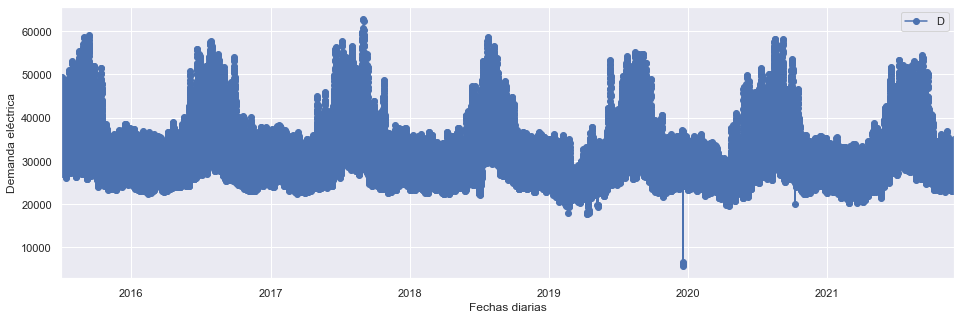

In [53]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_horarios_formato_1.plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x
plt.savefig("Demanda_energia_diaria.png", dpi=300, bbox_inches='tight')

Podemos observar que hay outliers a finales de 2019. Grafiquemos las series en esa fecha para ver el efecto.

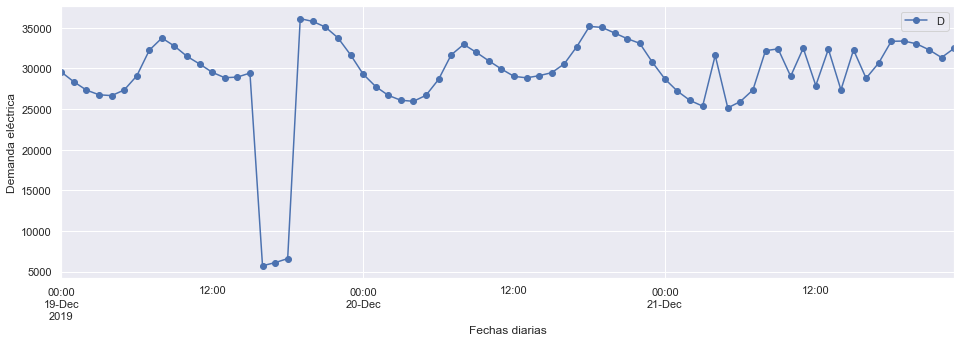

In [54]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_horarios_formato_1["2019-12-19":"2019-12-21"].plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x
plt.savefig("Demanda_energia_diaria_outlier2.png", dpi=300, bbox_inches='tight')

Veamos cuales son los valores exactos de la serie en esos puntos

In [55]:
datos_horarios_formato_1.loc["2019-12-19"]

,D
2019-12-19 00:00:00,29554.0
2019-12-19 01:00:00,28350.0
2019-12-19 02:00:00,27331.0
2019-12-19 03:00:00,26759.0
2019-12-19 04:00:00,26654.0
2019-12-19 05:00:00,27351.0
2019-12-19 06:00:00,29084.0
2019-12-19 07:00:00,32247.0
2019-12-19 08:00:00,33744.0
2019-12-19 09:00:00,32743.0


In [56]:
datos_horarios_formato_1

,D
2015-07-01 01:00:00,38210.0
2015-07-01 02:00:00,35171.0
2015-07-01 03:00:00,33243.0
2015-07-01 04:00:00,31955.0
2015-07-01 05:00:00,31199.0
...,...
2021-11-30 20:00:00,33941.0
2021-11-30 21:00:00,33098.0
2021-11-30 22:00:00,31768.0
2021-11-30 23:00:00,29751.0


Los valores atípicos se dan a las 16:00, 17:00 y 18:00. Y, a diferencia del caso anterior, en este caso no tenemos valores repetidos.

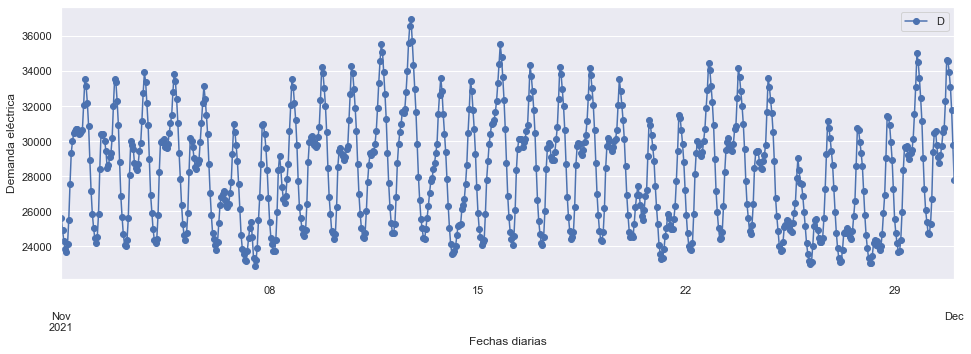

In [57]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_horarios_formato_1["2021-11":].plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x
plt.savefig("Demanda_energia_diaria.png", dpi=300, bbox_inches='tight')

### GUARDADO DE FICHEROS

In [62]:
table_diaria = pa.Table.from_pandas(datos_diarios, preserve_index=True)
pq.write_table(table_diaria, '/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/Practices/EXAM/Exam_data/datos_diarios.parquet')

In [63]:
table_horaria = pa.Table.from_pandas(datos_horarios_formato_1, preserve_index=True)
pq.write_table(table_horaria, '/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/Practices/EXAM/Exam_data/datos_horarios.parquet')